# **Feature Engineering Notebook**

## Objectives

* Engineer features for Classification, Regression and Cluster models

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv


## Outputs
* generate a list with variables to engineer

## Conclusions

* Feature Engineering Transformers
  * Ordinal categorical encodingp

---

# Change working directory

In [1]:
import numpy
import os

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues/jupyter_notebooks'

Change the working directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues'

---

# Load Cleanded Data

Train Set

In [5]:
import pandas as pd
TrainSet = pd.read_csv("outputs/datasets/cleaned/TrainSetCleaned.csv")
TrainSet.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1828       0.0      2.883272           Av          48         None   
1       894       0.0      2.000000           No           0          Unf   
2       964       0.0      2.000000           No         713          ALQ   
3      1689       0.0      3.000000           No        1218          GLQ   
4      1541       0.0      3.000000           No           0          Unf   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0       1774         774          Unf       2007.0  ...    11694   90.000000   
1        894         308         None       1962.0  ...     6600   60.000000   
2        163         432          Unf       1921.0  ...    13360   80.000000   
3        350         857          RFn       2002.0  ...    13265   69.614017   
4       1541         843          RFn       2001.0  ...    13704  118.000000   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0       452.0          108            5            9         1822       2007   
1         0.0            0            5            5          894       1962   
2         0.0            0            7            5          876       1921   
3       148.0           59            5            8         1568       2002   
4       150.0           81            5            7         1541       2001   

   YearRemodAdd  SalePrice  
0          2007     314813  
1          1962     109500  
2          2006     163500  
3          2002     271000  
4          2002     205000  

[5 rows x 22 columns]

Test Set

In [6]:
import pandas as pd
TestSet = pd.read_csv("outputs/datasets/cleaned/TestSetCleaned.csv")
TestSet.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      2515       0.0           4.0           No        1219          Rec   
1       958     620.0           3.0           No         403          BLQ   
2       979     224.0           3.0           No         185          LwQ   
3      1156     866.0           4.0           No         392          BLQ   
4       525       0.0           3.0           No           0          Unf   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0        816         484         None       1975.0  ...    32668   69.614017   
1        238         240          Unf       1941.0  ...     9490   79.000000   
2        524         352          Unf       1950.0  ...     7015   69.614017   
3        768         505          Fin       1977.0  ...    10005   83.000000   
4        525         264          Unf       1971.0  ...     1680   21.000000   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         0.0            0            3            6         2035       1957   
1         0.0            0            7            6          806       1941   
2       161.0            0            4            5          709       1950   
3       299.0          117            5            7         1160       1977   
4       381.0            0            5            6          525       1971   

   YearRemodAdd  SalePrice  
0          1975     200624  
1          1950     133000  
2          1950     110000  
3          1977     192000  
4          1971      88000  

[5 rows x 22 columns]

# Data Exploration

*Checking variable type and distribution, missing levels and what these variables mean in a business context*

In [7]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Feature Engineering

I use the OneHotEncoder to create more columns for each categorical option with binary values (0 or 1).

In [8]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

In [9]:
sns.set_style('whitegrid')
target_var = 'SalePrice'

def plot_target_hist(df, target_var):
  """
  Function to plot a histogram of the target and
  save the figure to folder.
  """
  plt.figure(figsize=(12, 5))
  sns.histplot(data=df, x=target_var, kde=True)
  plt.title(f"Distribution of {target_var}", fontsize=20)      
  plt.show()

plot_target_hist(df, target_var)

NameError: name 'df' is not defined

*Create a separate DataFrame and transform GarageArea (numerical) into bins (categorical) for visualising at parallel_categories() plot*

In [18]:
from feature_engine.discretisation import ArbitraryDiscretiser
import numpy as np
"1stFlrSF_map = [-np.Inf, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, np.Inf]"
GarageArea_map = [-np.Inf, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, np.Inf]
GarageYrBlt_map = [-np.Inf, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, np.Inf]
GrLivArea_map = [-np.Inf, 600, 1200, 1800, 2400, 3000, 3600, 4200, 4800, 5400, 6000, np.Inf]
MasVnrArea_map = [-np.Inf, 200, 400, 600, 800, 1000, 1200, 1400, 1600, np.Inf]
TotalBsmtSF_map = [-np.Inf, 600, 1200, 1800, 2400, 3000, 3600, 4200, 4800, 5400, 6000, 6600, np.Inf]
YearBuilt_map = [-np.Inf, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, np.Inf]
YearRemodAdd_map = [-np.Inf, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, np.Inf]
SalePrice_map = [-np.Inf, 35000, 70000, 105000, 140000, 175000, 210000, 245000, 280000, 315000, 350000, 385000, 415000, 450000, 485000, 515000, 550000, 585000, 615000, 650000, 685000, 715000, 750000, 785000, np.Inf]
disc = ArbitraryDiscretiser(binning_dict={'GarageArea':GarageArea_map, 'GarageYrBlt':GarageYrBlt_map, 'GrLivArea':GrLivArea_map, 'MasVnrArea':MasVnrArea_map, 'TotalBsmtSF':TotalBsmtSF_map, 'YearBuilt':YearBuilt_map, 'YearRemodAdd':YearRemodAdd_map, 'SalePrice':SalePrice_map,})
df_parallel = disc.fit_transform(df_eda)
df_parallel.head()

1stFlrSF  GarageArea  GarageYrBlt  GrLivArea KitchenQual  MasVnrArea  \
0       856           5           13          2          Gd           0   
1      1262           4           10          2          TA           0   
2       920           6           13          2          Gd           0   
3       961           6           12          2          Gd           0   
4      1145           8           12          3          Gd           1   

   OverallQual  TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0            7            1         13            13          5  
1            6            2         10            10          5  
2            7            1         13            13          6  
3            7            1          4             9          3  
4            8            1         12            12          7

In [19]:
disc.binner_dict_['GarageArea']

[-inf,
 100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 inf]

In [29]:
n_classes = len(GarageArea_map) - 1
classes_ranges = disc.binner_dict_['GarageArea'][1:-1]

GarageArea_labels_map = {}
for n in range(0, n_classes):
    if n == 0:
        GarageArea_labels_map[n] = f"<{classes_ranges[0]}"
    elif n == n_classes-1:
        GarageArea_labels_map[n] = f"+{classes_ranges[-1]}"
    else:
        GarageArea_labels_map[n] = f"{classes_ranges[n-1]} to {classes_ranges[n]}"

GarageArea_labels_map

{0: '<100',
 1: '100 to 200',
 2: '200 to 300',
 3: '300 to 400',
 4: '400 to 500',
 5: '500 to 600',
 6: '600 to 700',
 7: '700 to 800',
 8: '800 to 900',
 9: '900 to 1000',
 10: '1000 to 1100',
 11: '1100 to 1200',
 12: '1200 to 1300',
 13: '1300 to 1400',
 14: '1400 to 1500',
 15: '+1500'}

In [21]:
n_classes = len(GarageYrBlt_map) - 1
classes_ranges = disc.binner_dict_['GarageYrBlt'][1:-1]

GarageYrBlt_labels_map = {}
for n in range(0, n_classes):
    if n == 0:
        GarageYrBlt_labels_map[n] = f"<{classes_ranges[0]}"
    elif n == n_classes-1:
        GarageYrBlt_labels_map[n] = f"+{classes_ranges[-1]}"
    else:
        GarageYrBlt_labels_map[n] = f"{classes_ranges[n-1]} to {classes_ranges[n]}"

GarageYrBlt_labels_map

{0: '<1880',
 1: '1880 to 1890',
 2: '1890 to 1900',
 3: '1900 to 1910',
 4: '1910 to 1920',
 5: '1920 to 1930',
 6: '1930 to 1940',
 7: '1940 to 1950',
 8: '1950 to 1960',
 9: '1960 to 1970',
 10: '1970 to 1980',
 11: '1980 to 1990',
 12: '1990 to 2000',
 13: '2000 to 2010',
 14: '+2010'}

In [22]:
n_classes = len(GrLivArea_map) - 1
classes_ranges = disc.binner_dict_['GrLivArea'][1:-1]

GrLivArea_labels_map = {}
for n in range(0, n_classes):
    if n == 0:
        GrLivArea_labels_map[n] = f"<{classes_ranges[0]}"
    elif n == n_classes-1:
        GrLivArea_labels_map[n] = f"+{classes_ranges[-1]}"
    else:
        GrLivArea_labels_map[n] = f"{classes_ranges[n-1]} to {classes_ranges[n]}"

GrLivArea_labels_map

{0: '<600',
 1: '600 to 1200',
 2: '1200 to 1800',
 3: '1800 to 2400',
 4: '2400 to 3000',
 5: '3000 to 3600',
 6: '3600 to 4200',
 7: '4200 to 4800',
 8: '4800 to 5400',
 9: '5400 to 6000',
 10: '+6000'}

In [23]:
n_classes = len(MasVnrArea_map) - 1
classes_ranges = disc.binner_dict_['MasVnrArea'][1:-1]

MasVnrArea_labels_map = {}
for n in range(0, n_classes):
    if n == 0:
        MasVnrArea_labels_map[n] = f"<{classes_ranges[0]}"
    elif n == n_classes-1:
        MasVnrArea_labels_map[n] = f"+{classes_ranges[-1]}"
    else:
        MasVnrArea_labels_map[n] = f"{classes_ranges[n-1]} to {classes_ranges[n]}"

MasVnrArea_labels_map

{0: '<200',
 1: '200 to 400',
 2: '400 to 600',
 3: '600 to 800',
 4: '800 to 1000',
 5: '1000 to 1200',
 6: '1200 to 1400',
 7: '1400 to 1600',
 8: '+1600'}

In [24]:
n_classes = len(TotalBsmtSF_map) - 1
classes_ranges = disc.binner_dict_['TotalBsmtSF'][1:-1]

TotalBsmtSF_labels_map = {}
for n in range(0, n_classes):
    if n == 0:
        TotalBsmtSF_labels_map[n] = f"<{classes_ranges[0]}"
    elif n == n_classes-1:
        TotalBsmtSF_labels_map[n] = f"+{classes_ranges[-1]}"
    else:
        TotalBsmtSF_labels_map[n] = f"{classes_ranges[n-1]} to {classes_ranges[n]}"

TotalBsmtSF_labels_map

{0: '<600',
 1: '600 to 1200',
 2: '1200 to 1800',
 3: '1800 to 2400',
 4: '2400 to 3000',
 5: '3000 to 3600',
 6: '3600 to 4200',
 7: '4200 to 4800',
 8: '4800 to 5400',
 9: '5400 to 6000',
 10: '6000 to 6600',
 11: '+6600'}

In [25]:
n_classes = len(YearBuilt_map) - 1
classes_ranges = disc.binner_dict_['YearBuilt'][1:-1]

YearBuilt_labels_map = {}
for n in range(0, n_classes):
    if n == 0:
        YearBuilt_labels_map[n] = f"<{classes_ranges[0]}"
    elif n == n_classes-1:
        YearBuilt_labels_map[n] = f"+{classes_ranges[-1]}"
    else:
        YearBuilt_labels_map[n] = f"{classes_ranges[n-1]} to {classes_ranges[n]}"

YearBuilt_labels_map

{0: '<1880',
 1: '1880 to 1890',
 2: '1890 to 1900',
 3: '1900 to 1910',
 4: '1910 to 1920',
 5: '1920 to 1930',
 6: '1930 to 1940',
 7: '1940 to 1950',
 8: '1950 to 1960',
 9: '1960 to 1970',
 10: '1970 to 1980',
 11: '1980 to 1990',
 12: '1990 to 2000',
 13: '2000 to 2010',
 14: '+2010'}

In [26]:
n_classes = len(YearRemodAdd_map) - 1
classes_ranges = disc.binner_dict_['YearRemodAdd'][1:-1]

YearRemodAdd_labels_map = {}
for n in range(0, n_classes):
    if n == 0:
        YearRemodAdd_labels_map[n] = f"<{classes_ranges[0]}"
    elif n == n_classes-1:
        YearRemodAdd_labels_map[n] = f"+{classes_ranges[-1]}"
    else:
        YearRemodAdd_labels_map[n] = f"{classes_ranges[n-1]} to {classes_ranges[n]}"

YearRemodAdd_labels_map

{0: '<1880',
 1: '1880 to 1890',
 2: '1890 to 1900',
 3: '1900 to 1910',
 4: '1910 to 1920',
 5: '1920 to 1930',
 6: '1930 to 1940',
 7: '1940 to 1950',
 8: '1950 to 1960',
 9: '1960 to 1970',
 10: '1970 to 1980',
 11: '1980 to 1990',
 12: '1990 to 2000',
 13: '2000 to 2010',
 14: '+2010'}

In [27]:
n_classes = len(SalePrice_map) - 1
classes_ranges = disc.binner_dict_['SalePrice'][1:-1]

SalePrice_labels_map = {}
for n in range(0, n_classes):
    if n == 0:
        SalePrice_labels_map[n] = f"<{classes_ranges[0]}"
    elif n == n_classes-1:
        SalePrice_labels_map[n] = f"+{classes_ranges[-1]}"
    else:
        SalePrice_labels_map[n] = f"{classes_ranges[n-1]} to {classes_ranges[n]}"

SalePrice_labels_map

{0: '<35000',
 1: '35000 to 70000',
 2: '70000 to 105000',
 3: '105000 to 140000',
 4: '140000 to 175000',
 5: '175000 to 210000',
 6: '210000 to 245000',
 7: '245000 to 280000',
 8: '280000 to 315000',
 9: '315000 to 350000',
 10: '350000 to 385000',
 11: '385000 to 415000',
 12: '415000 to 450000',
 13: '450000 to 485000',
 14: '485000 to 515000',
 15: '515000 to 550000',
 16: '550000 to 585000',
 17: '585000 to 615000',
 18: '615000 to 650000',
 19: '650000 to 685000',
 20: '685000 to 715000',
 21: '715000 to 750000',
 22: '750000 to 785000',
 23: '+785000'}

In [21]:
df_parallel['GarageArea'] = df_parallel['GarageArea'].replace(labels_map)
df_parallel.head()

1stFlrSF  GarageArea  GarageYrBlt  GrLivArea KitchenQual  MasVnrArea  \
0       856  500 to 600       2003.0       1710          Gd       196.0   
1      1262  400 to 500       1976.0       1262          TA         0.0   
2       920  600 to 700       2001.0       1786          Gd       162.0   
3       961  600 to 700       1998.0       1717          Gd         0.0   
4      1145  800 to 900       2000.0       2198          Gd       350.0   

   OverallQual  TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0            7          856       2003          2003     208500  
1            6         1262       1976          1976     181500  
2            7          920       2001          2002     223500  
3            7          756       1915          1970     140000  
4            8         1145       2000          2000     250000

In [30]:
df_parallel['GarageArea'] = df_parallel['GarageArea'].replace(GarageArea_labels_map)
df_parallel['GarageYrBlt'] = df_parallel['GarageYrBlt'].replace(GarageYrBlt_labels_map)
df_parallel['GrLivArea'] = df_parallel['GrLivArea'].replace(GrLivArea_labels_map)
df_parallel['MasVnrArea'] = df_parallel['MasVnrArea'].replace(MasVnrArea_labels_map)
df_parallel['TotalBsmtSF'] = df_parallel['TotalBsmtSF'].replace(TotalBsmtSF_labels_map)
df_parallel['YearBuilt'] = df_parallel['YearBuilt'].replace(YearBuilt_labels_map)
df_parallel['YearRemodAdd'] = df_parallel['YearRemodAdd'].replace(YearRemodAdd_labels_map)
df_parallel['SalePrice'] = df_parallel['SalePrice'].replace(SalePrice_labels_map)
df_parallel.head()

1stFlrSF  GarageArea   GarageYrBlt     GrLivArea KitchenQual  MasVnrArea  \
0       856  500 to 600  2000 to 2010  1200 to 1800          Gd        <200   
1      1262  400 to 500  1970 to 1980  1200 to 1800          TA        <200   
2       920  600 to 700  2000 to 2010  1200 to 1800          Gd        <200   
3       961  600 to 700  1990 to 2000  1200 to 1800          Gd        <200   
4      1145  800 to 900  1990 to 2000  1800 to 2400          Gd  200 to 400   

   OverallQual   TotalBsmtSF     YearBuilt  YearRemodAdd         SalePrice  
0            7   600 to 1200  2000 to 2010  2000 to 2010  175000 to 210000  
1            6  1200 to 1800  1970 to 1980  1970 to 1980  175000 to 210000  
2            7   600 to 1200  2000 to 2010  2000 to 2010  210000 to 245000  
3            7   600 to 1200  1910 to 1920  1960 to 1970  105000 to 140000  
4            8   600 to 1200  1990 to 2000  1990 to 2000  245000 to 280000

*Creates multi-dimensional categorical data plot*

In [31]:
import plotly.express as px
fig = px.parallel_categories(df_parallel, color="SalePrice")
fig.show()

ValueError: 
    Invalid element(s) received for the 'color' property of parcats.line
        Invalid elements include: ['175000 to 210000', '175000 to 210000', '210000 to 245000', '105000 to 140000', '245000 to 280000', '140000 to 175000', '280000 to 315000', '175000 to 210000', '105000 to 140000', '105000 to 140000']

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color:
            aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, rebeccapurple, saddlebrown, salmon,
            sandybrown, seagreen, seashell, sienna, silver,
            skyblue, slateblue, slategray, slategrey, snow,
            springgreen, steelblue, tan, teal, thistle, tomato,
            turquoise, violet, wheat, white, whitesmoke,
            yellow, yellowgreen
      - A number that will be interpreted as a color
        according to parcats.line.colorscale
      - A list or array of any of the above

*Create a map to replace the GarageArea variable with more informative levels.*

*Replace using .replace()*

---

## Feature Engineering Summary

* Consider the notes taken in your spreadsheet summary. List the transformers you will use
  * CCategorical Encodin
  * Numerical Transformation
  * Smart Correlation Selectionion

## Dealing with Feature Engineering

### Categorical Encoding - Ordinal: replaces categories with ordinal numbers

* Step 1: Select variable(s)

In [10]:
variables_engineering= ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
variables_engineering

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

* Step 2: Create a separate DataFrame, with your variable(s)

In [11]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head()

BsmtExposure BsmtFinType1 GarageFinish KitchenQual
0           Av         None          Unf          Gd
1           No          Unf         None          TA
2           No          ALQ          Unf          TA
3           No          GLQ          RFn          Gd
4           No          Unf          RFn          Gd

* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



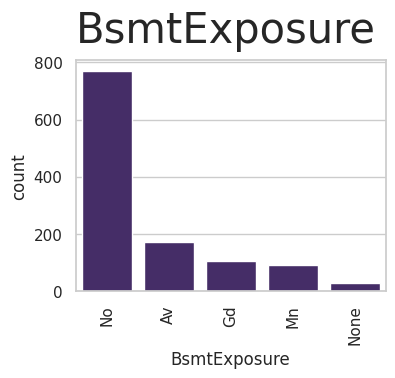

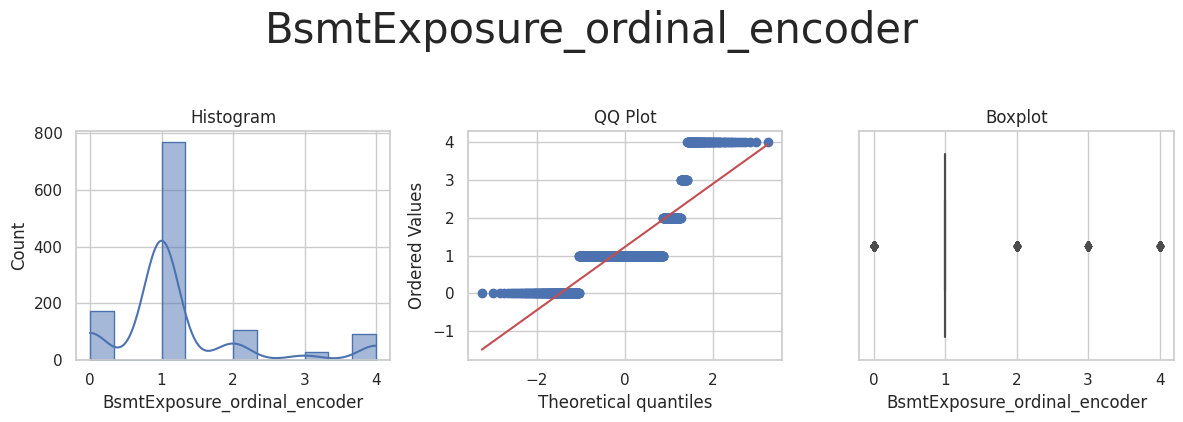



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



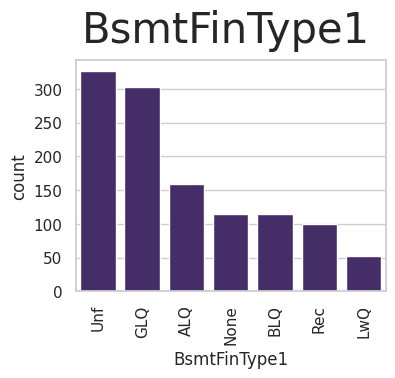

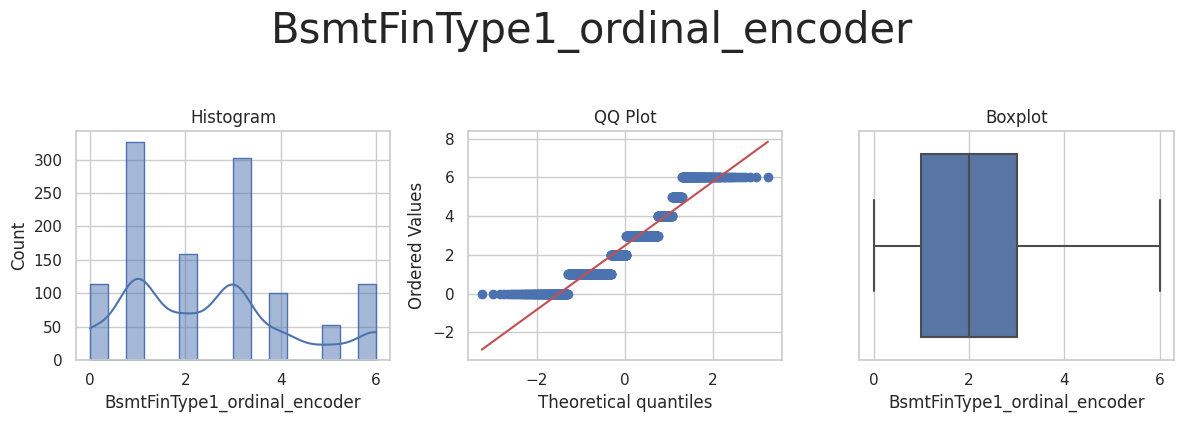



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



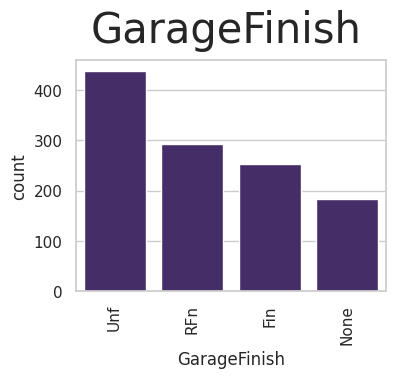

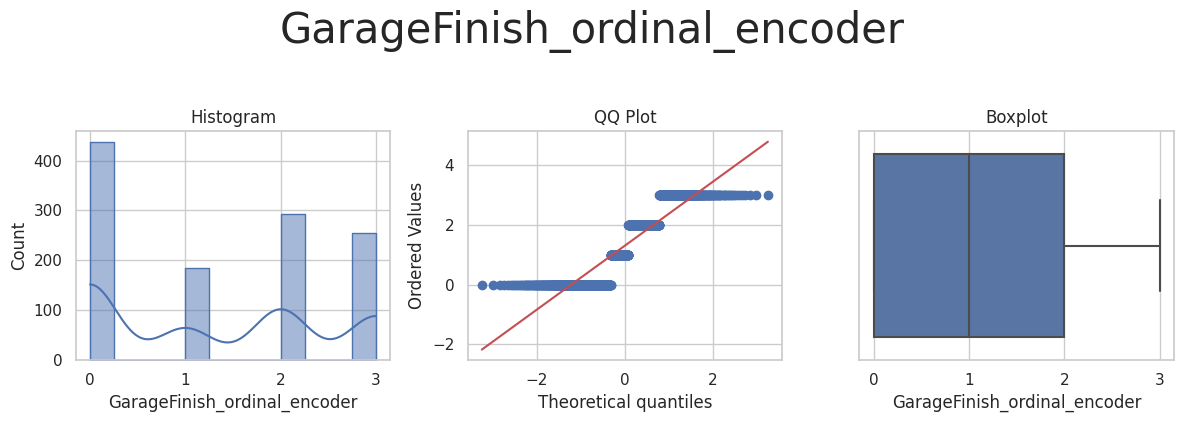



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



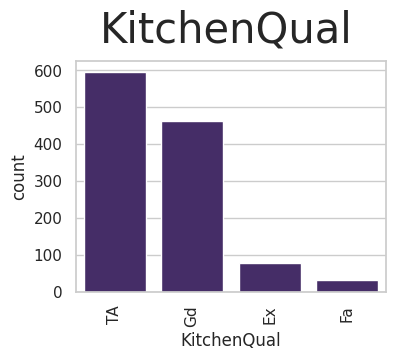

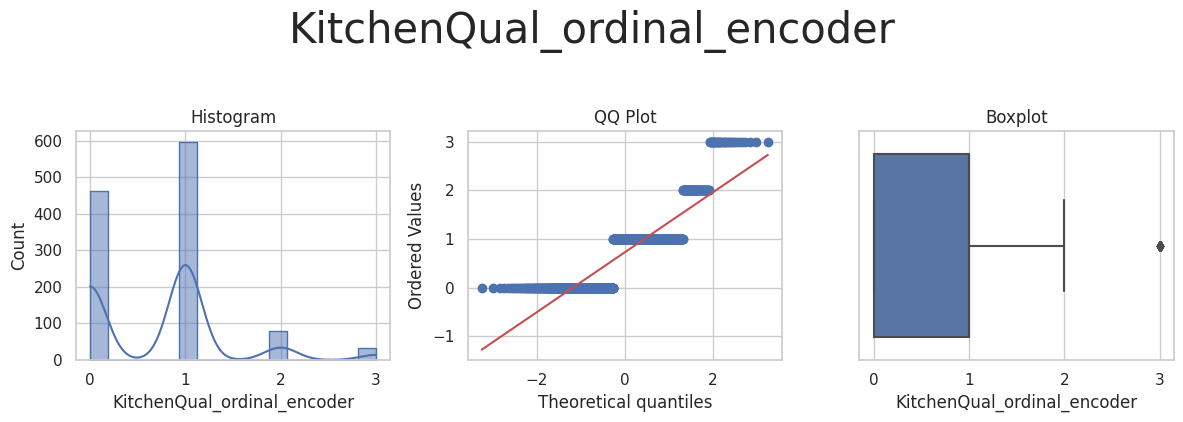

In [12]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

* WRITE CONCLUSIONS1

* Step 4 - Apply the selected transformation to the Train and Test set

In [13]:
# the steps are: 
# 1 - create a transformer
# 2 - fit_transform into TrainSet
# 3 - transform into TestSet 
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


### Numerical Transformation

In [14]:
variables_engineering = ['GrLivArea', 'LotArea', 'LotFrontage', 'GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', 'BsmtFinSF1', '1stFlrSF', '2ndFlrSF']
variables_engineering

['GrLivArea',
 'LotArea',
 'LotFrontage',
 'GarageArea',
 'MasVnrArea',
 'OpenPorchSF',
 'TotalBsmtSF',
 'BsmtFinSF1',
 '1stFlrSF',
 '2ndFlrSF']

In [15]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head()

GrLivArea  LotArea  LotFrontage  GarageArea  MasVnrArea  OpenPorchSF  \
0       1828    11694    90.000000         774       452.0          108   
1        894     6600    60.000000         308         0.0            0   
2        964    13360    80.000000         432         0.0            0   
3       1689    13265    69.614017         857       148.0           59   
4       1541    13704   118.000000         843       150.0           81   

   TotalBsmtSF  BsmtFinSF1  1stFlrSF  2ndFlrSF  
0         1822          48      1828       0.0  
1          894           0       894       0.0  
2          876         713       964       0.0  
3         1568        1218      1689       0.0  
4         1541           0      1541       0.0

* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



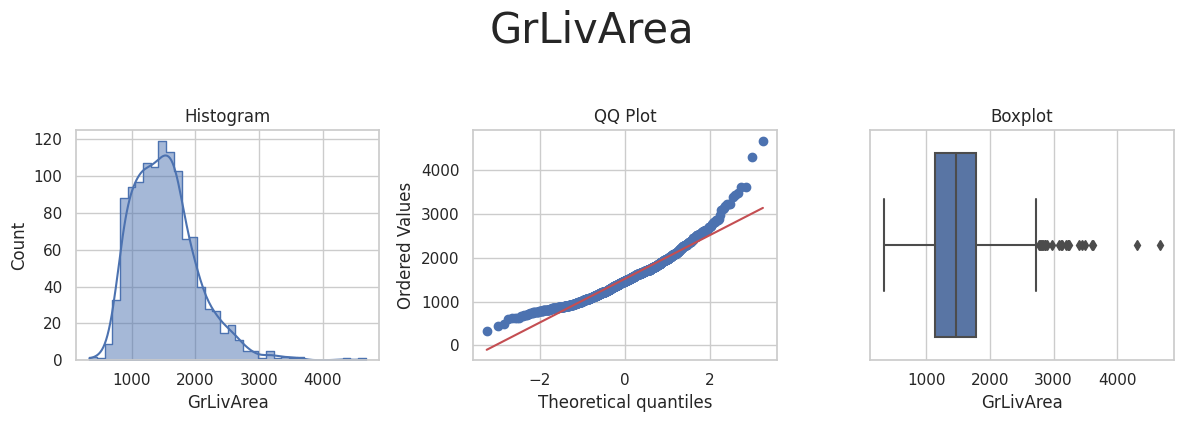

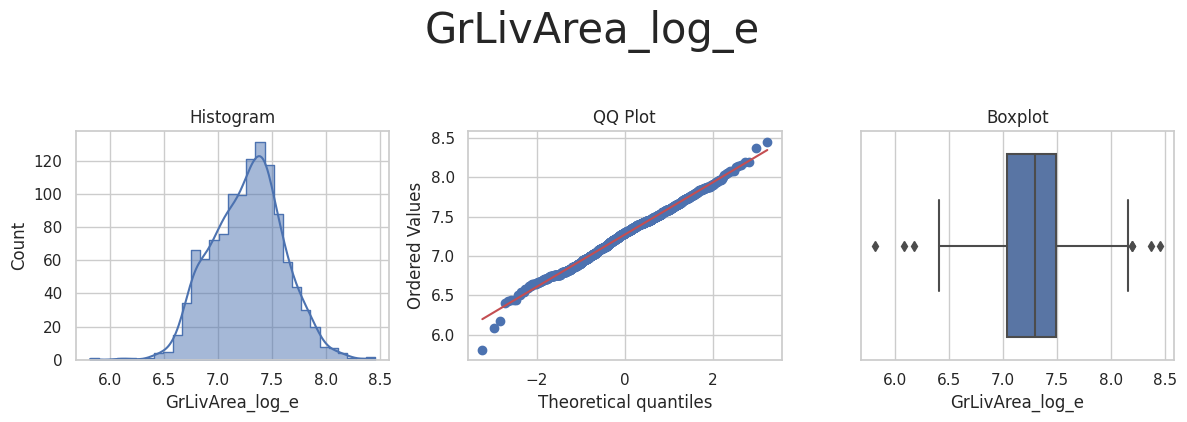

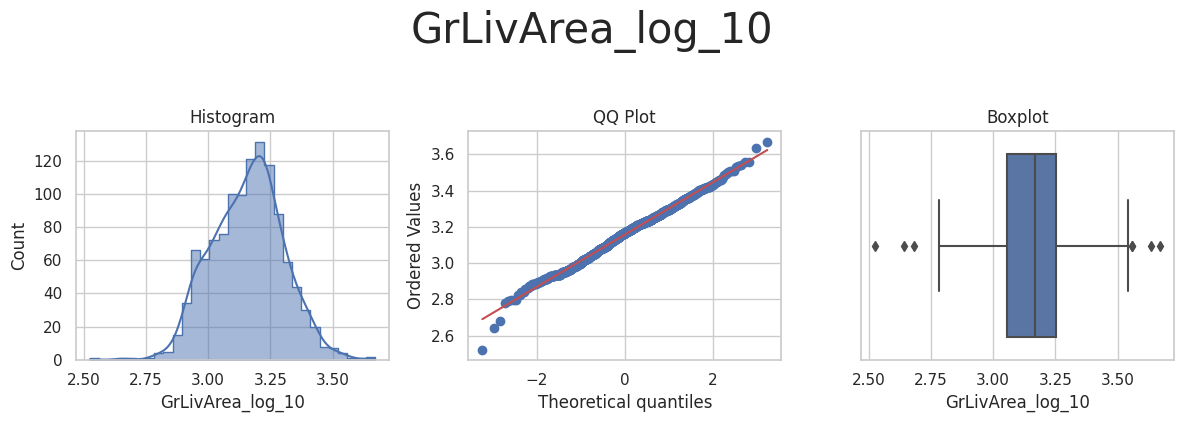

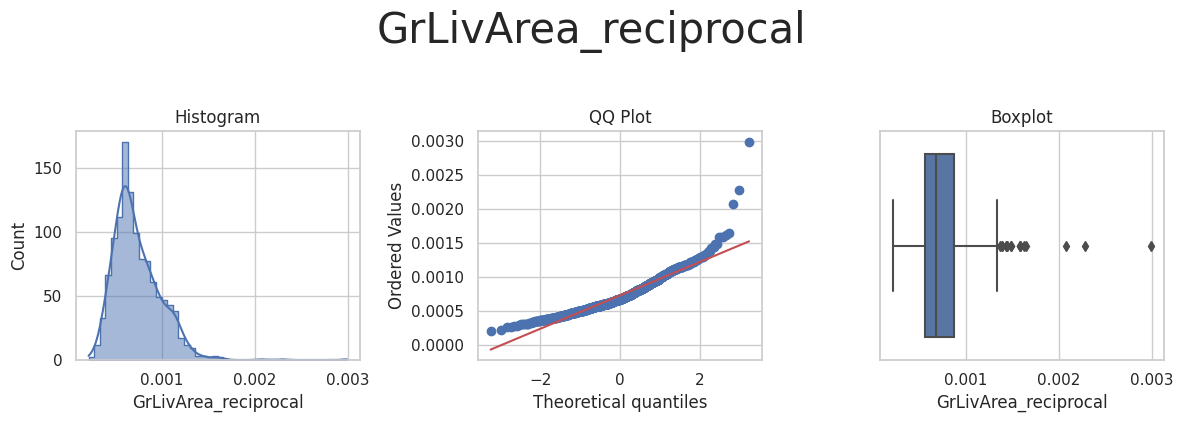

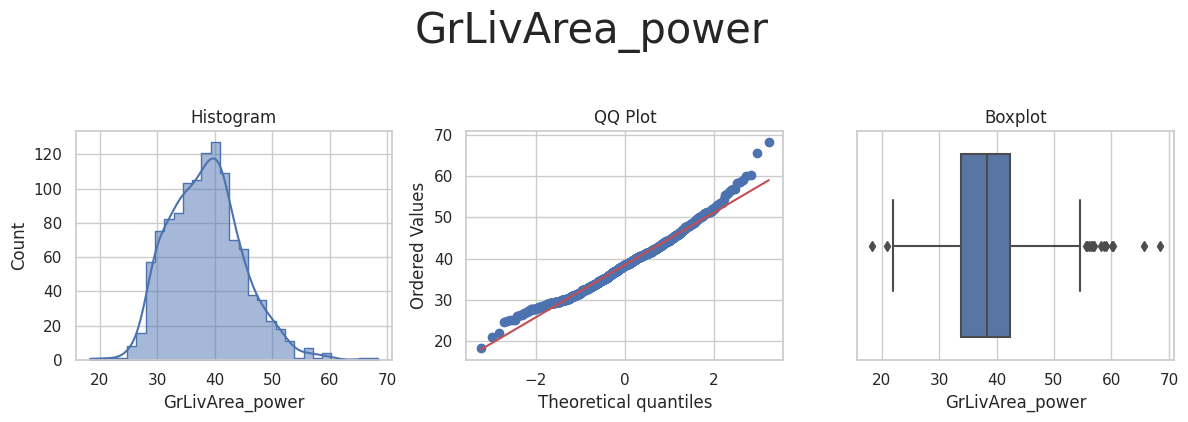

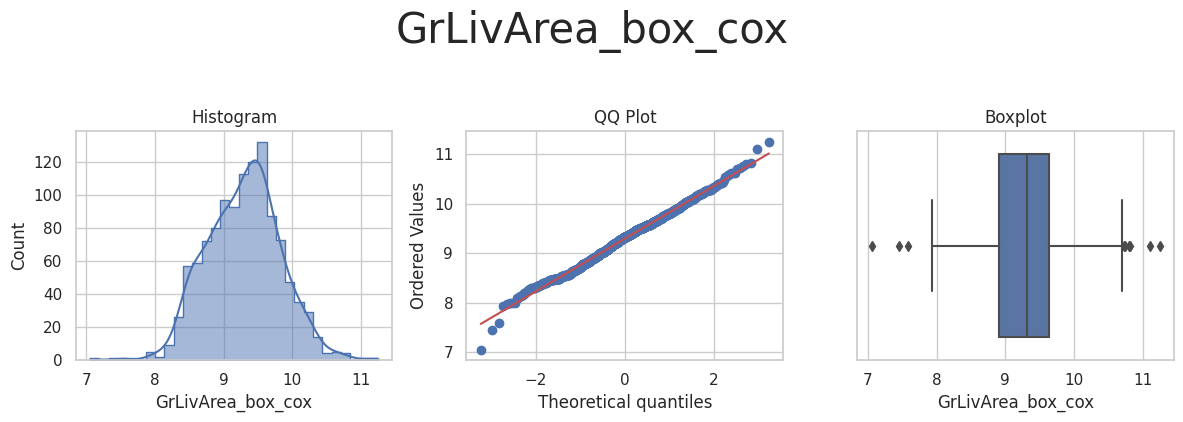

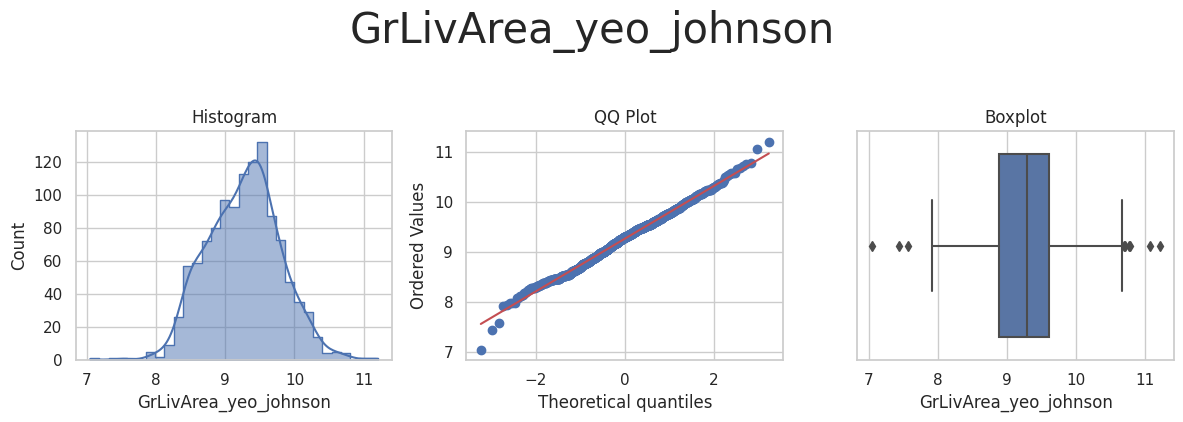



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



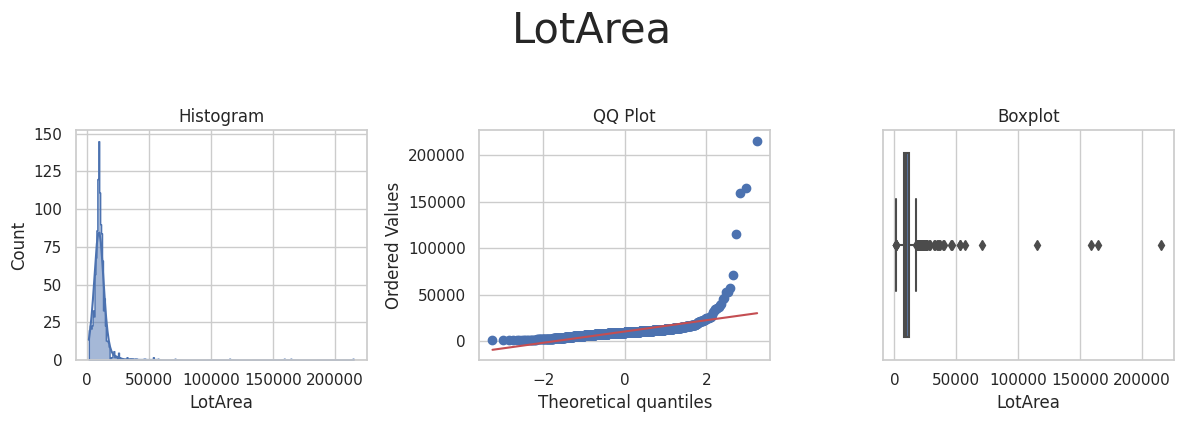

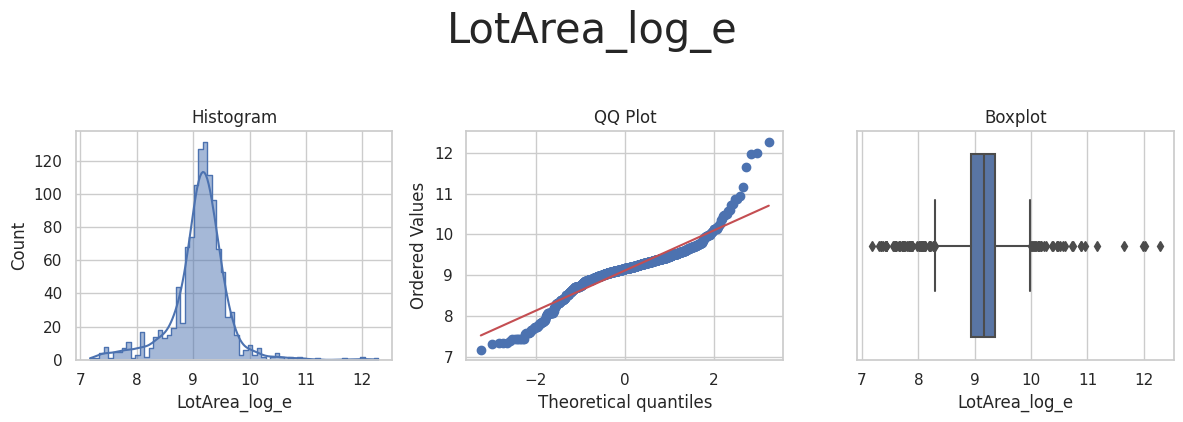

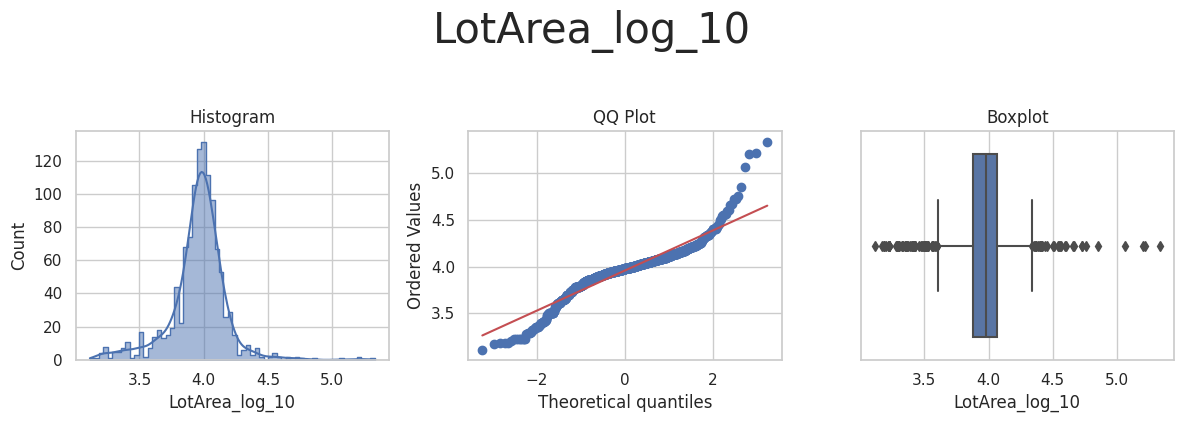

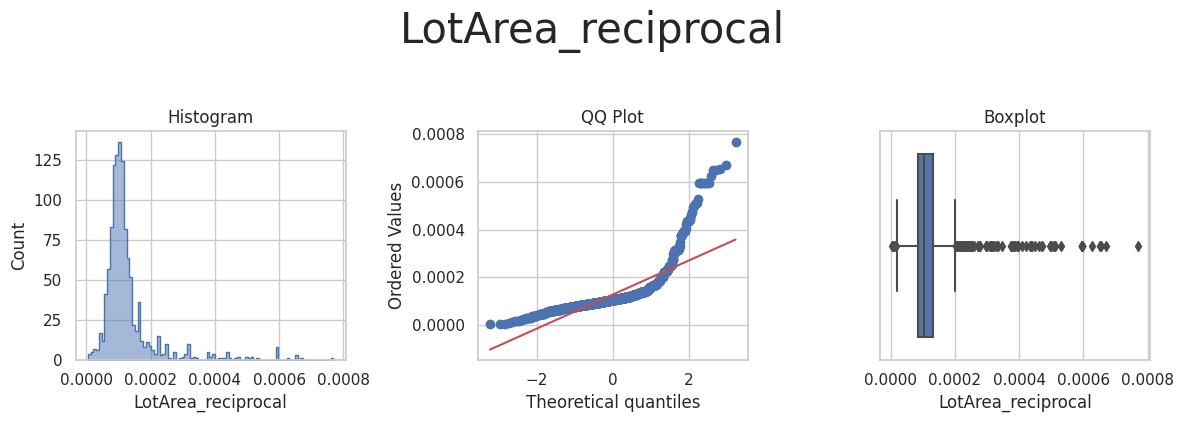

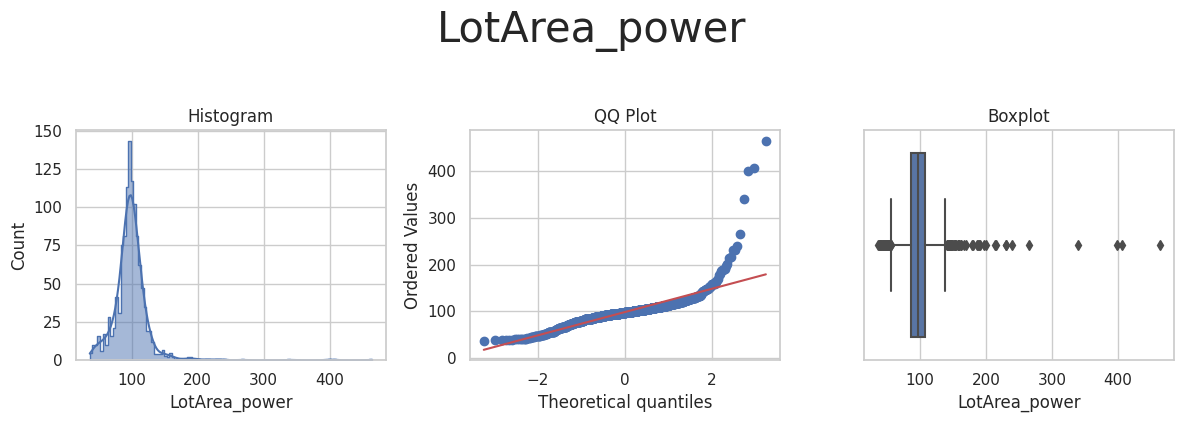

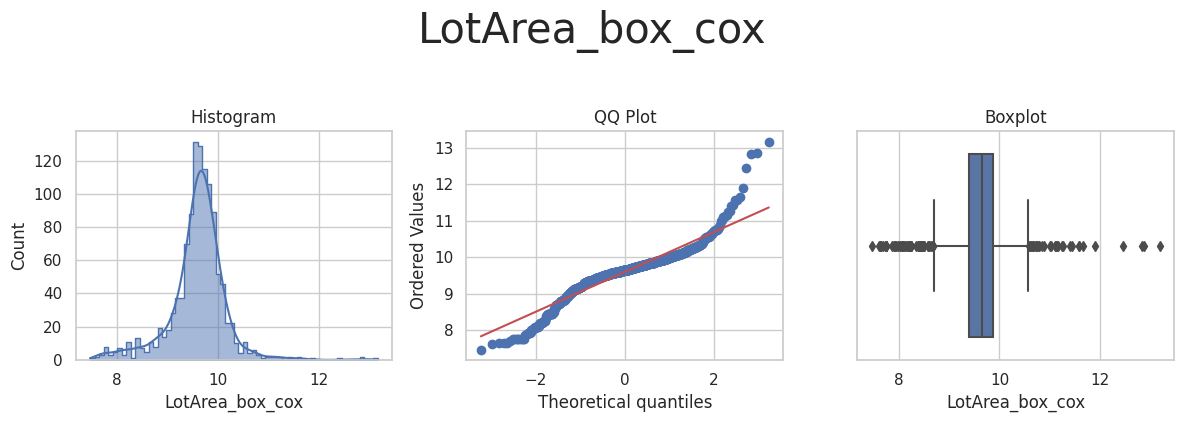

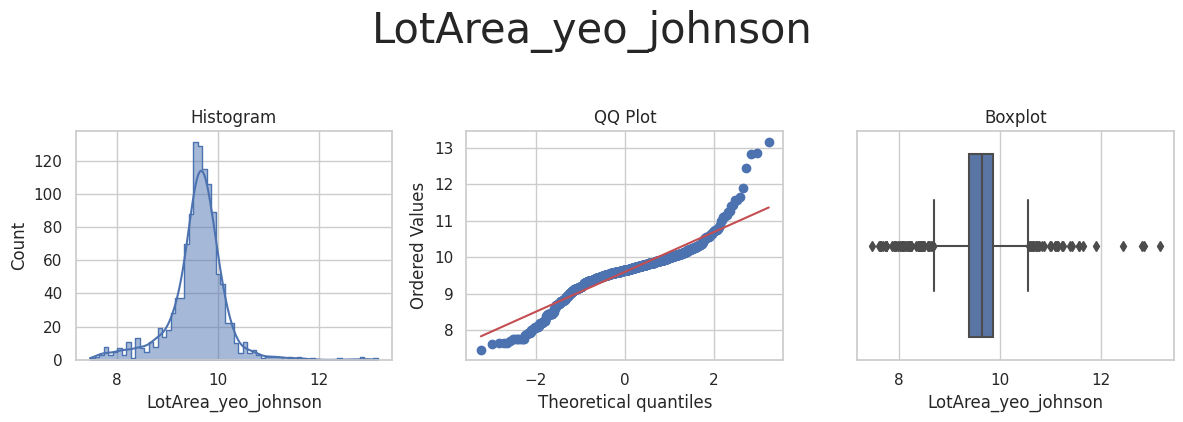



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



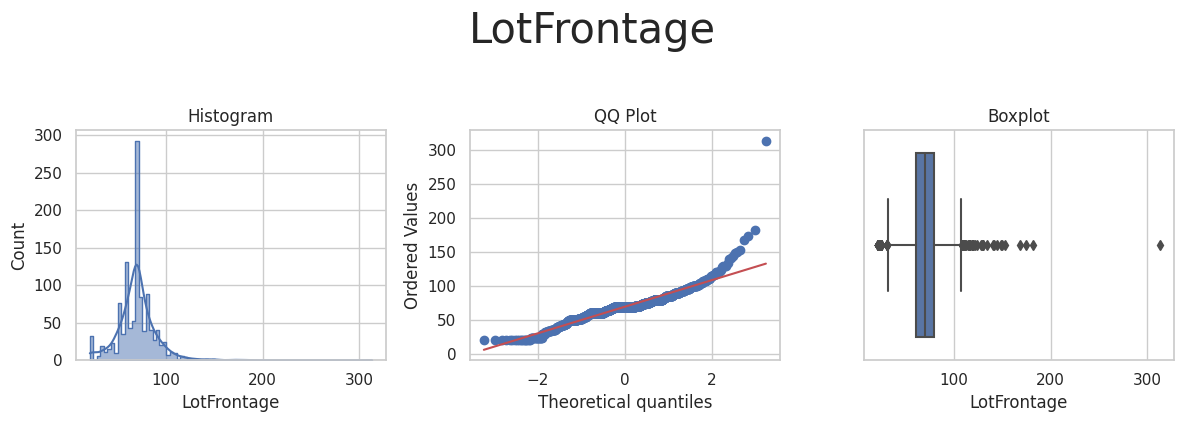

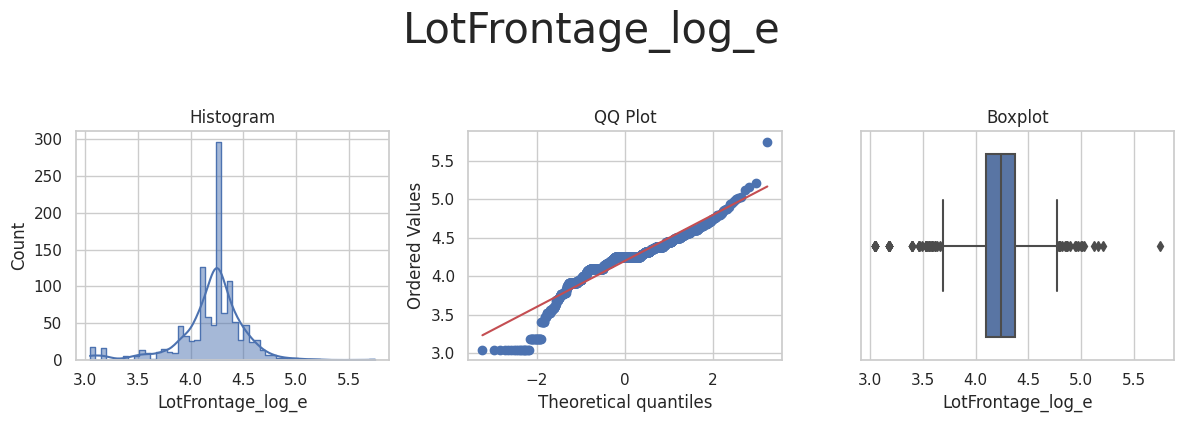

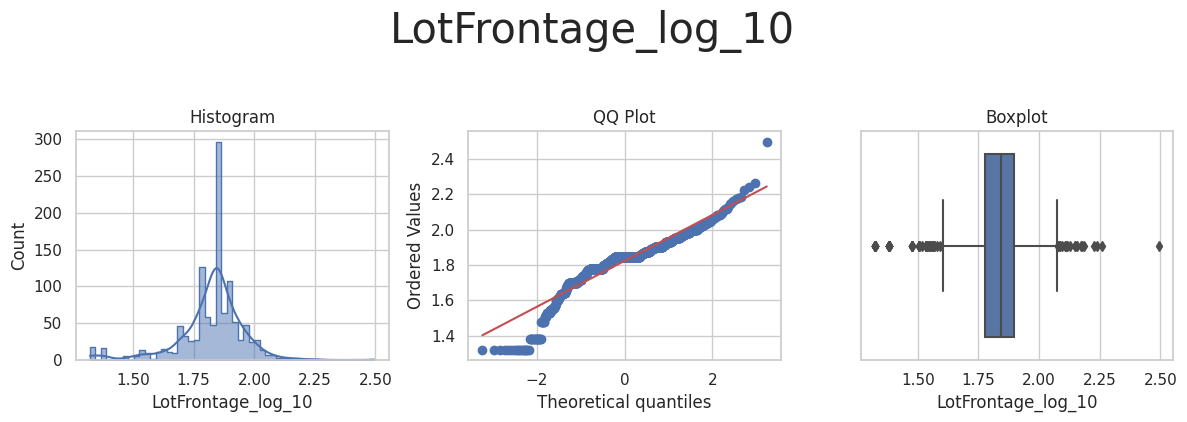

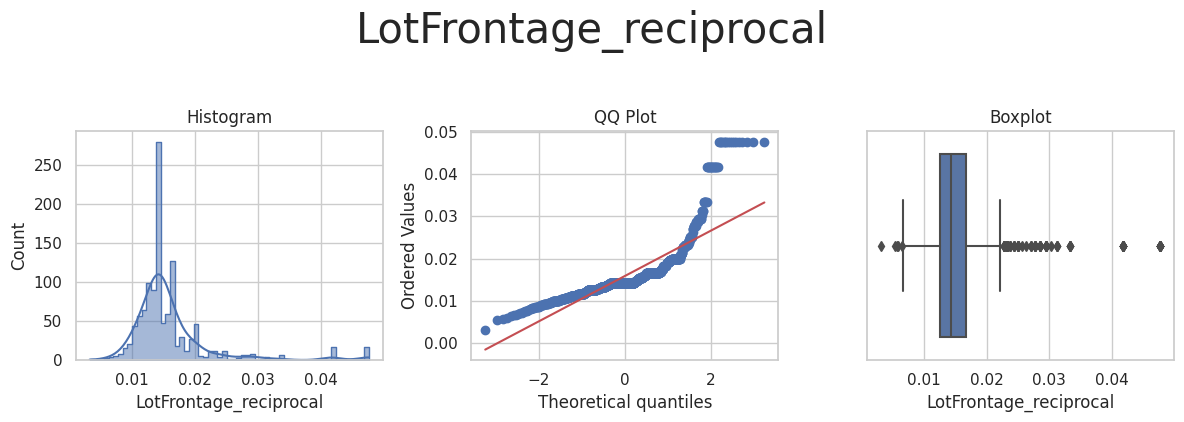

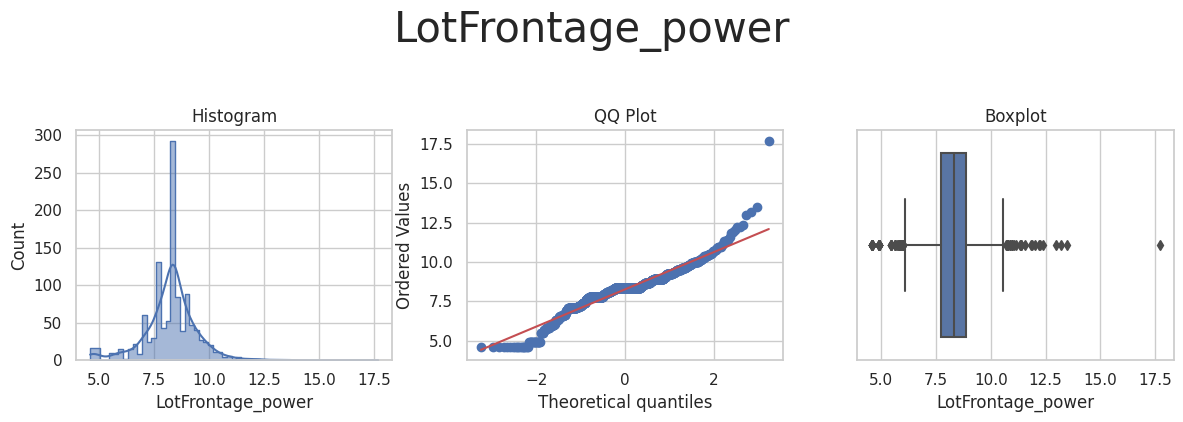

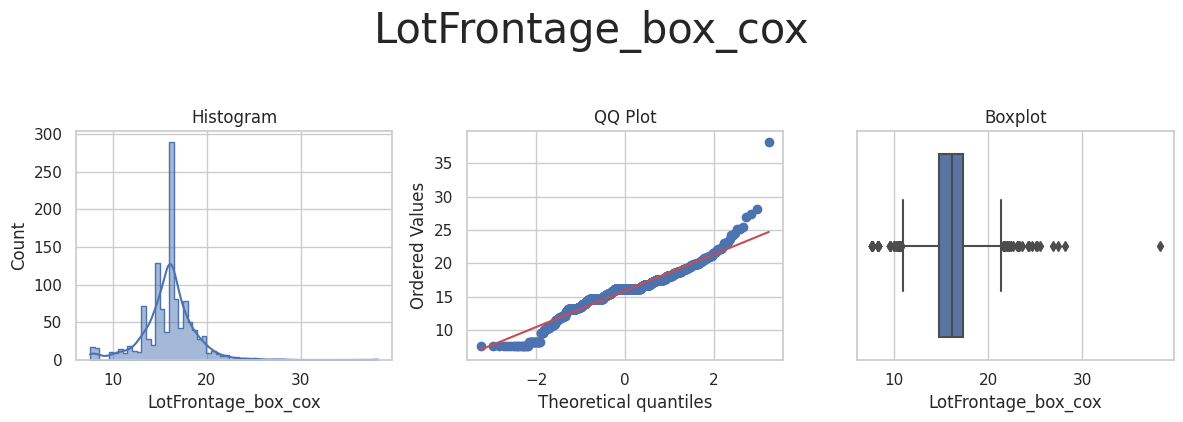

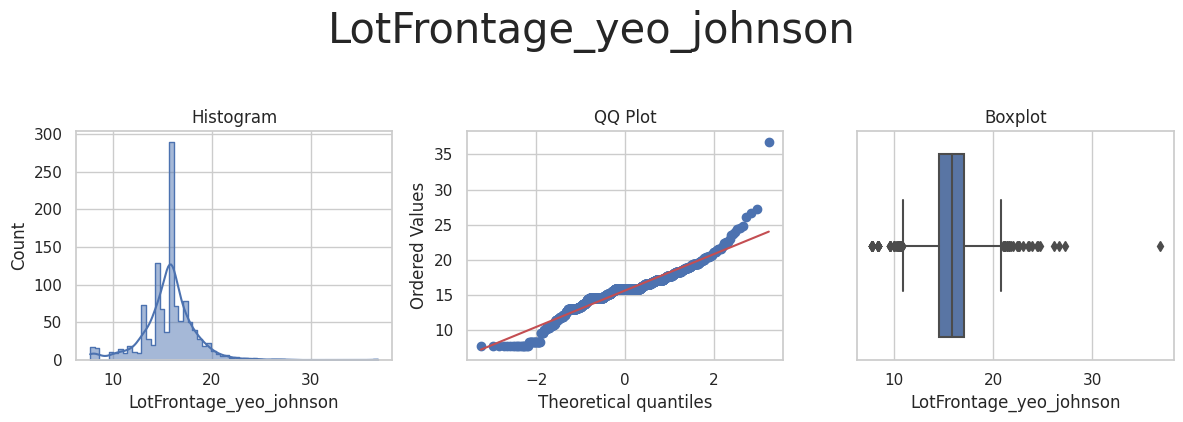



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



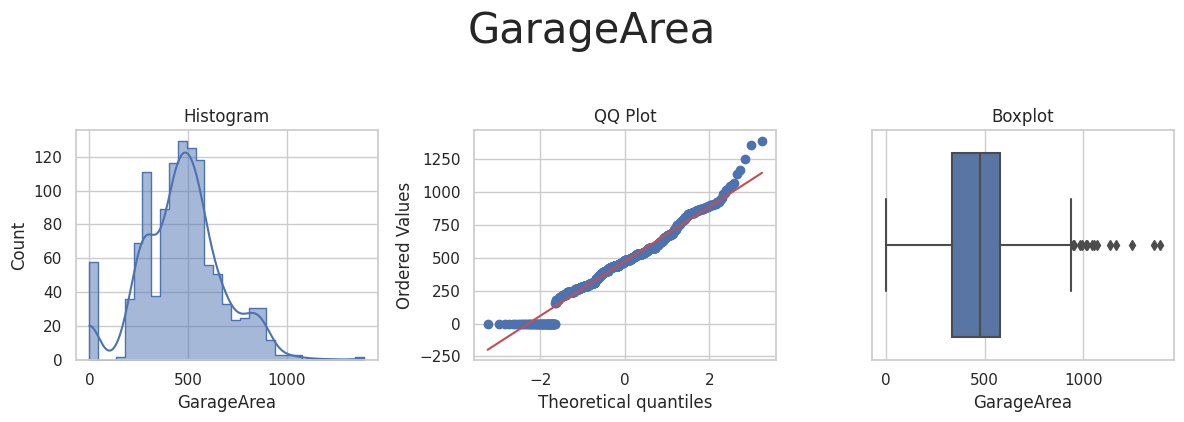

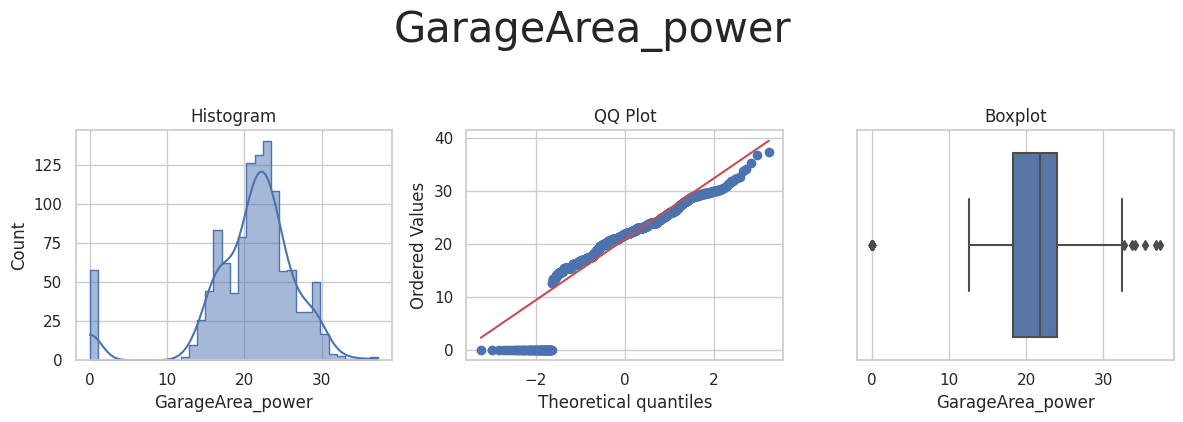

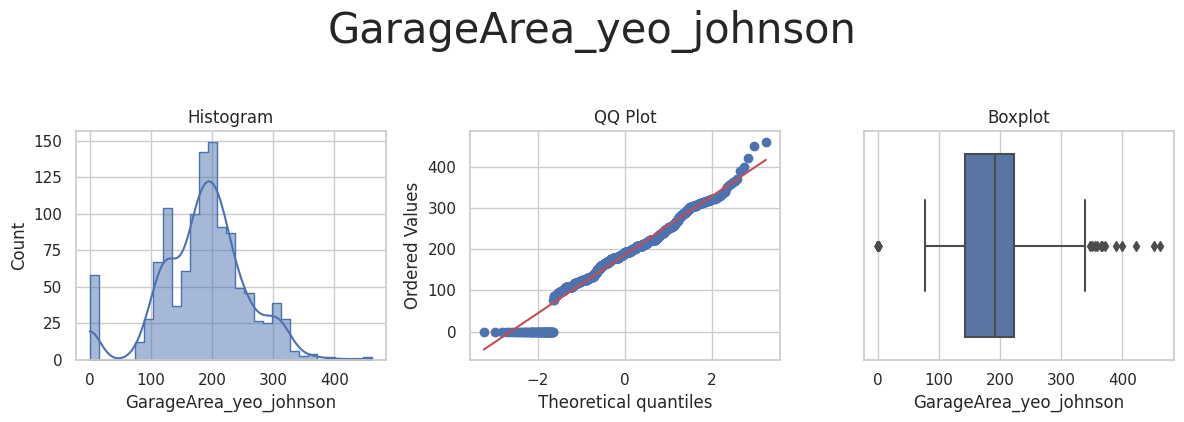



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



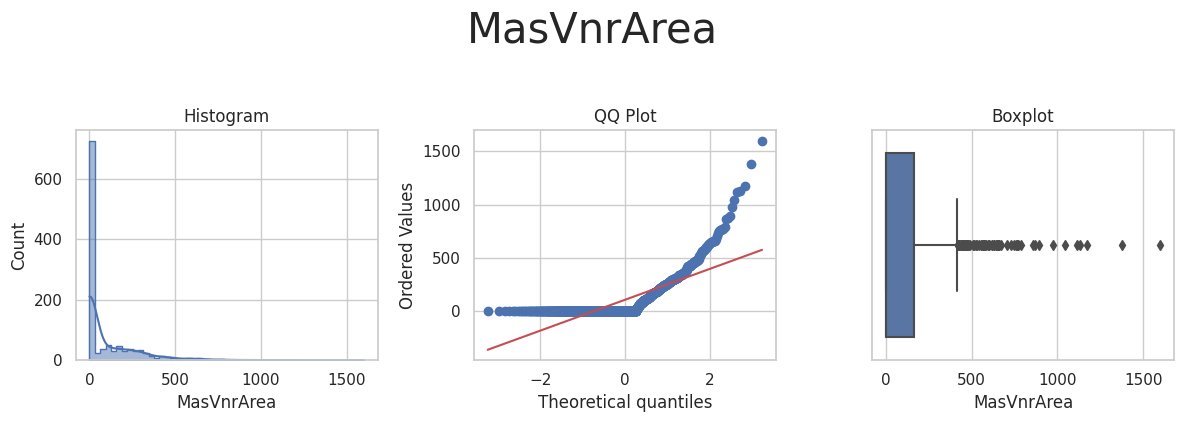

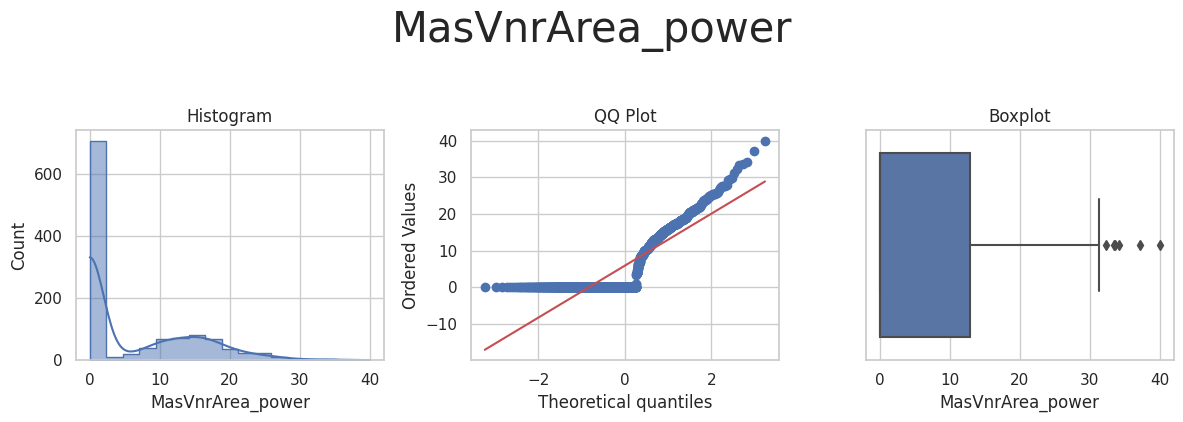

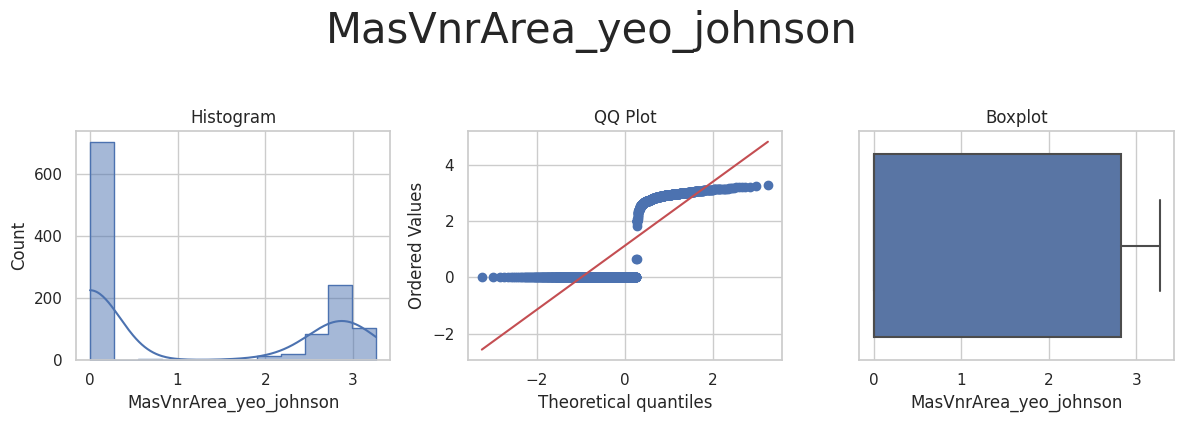



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



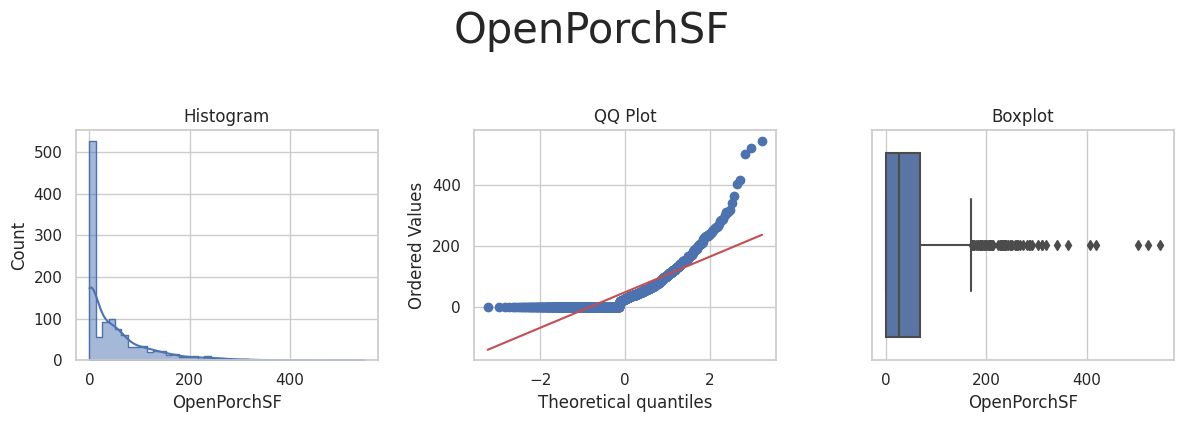

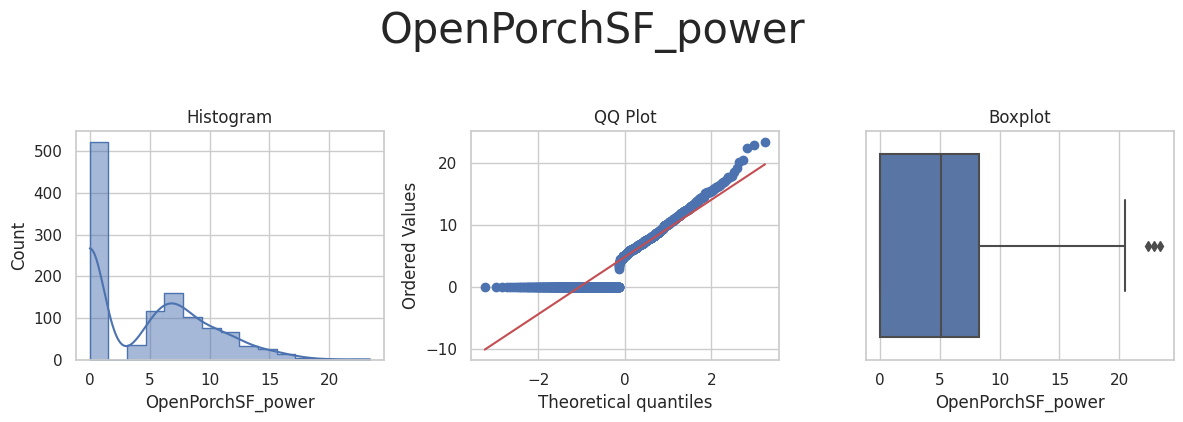

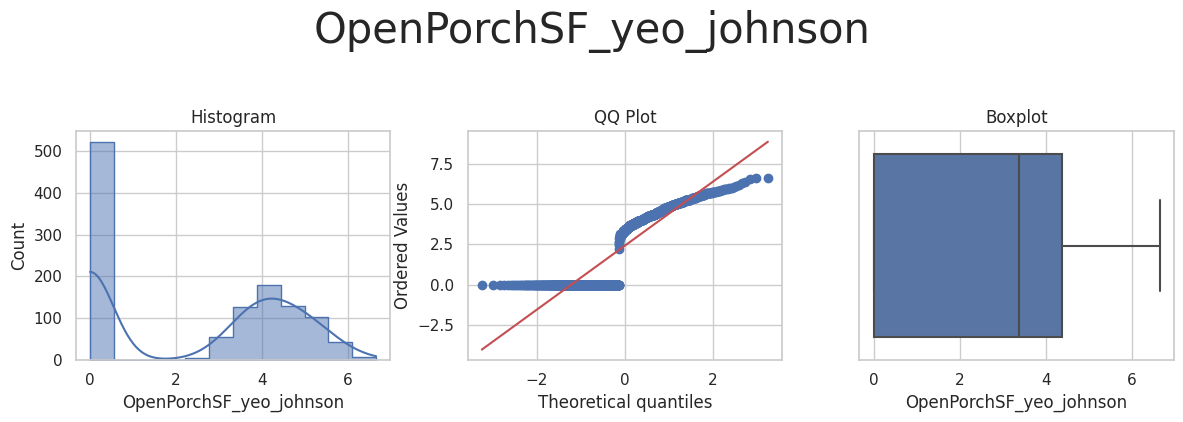



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



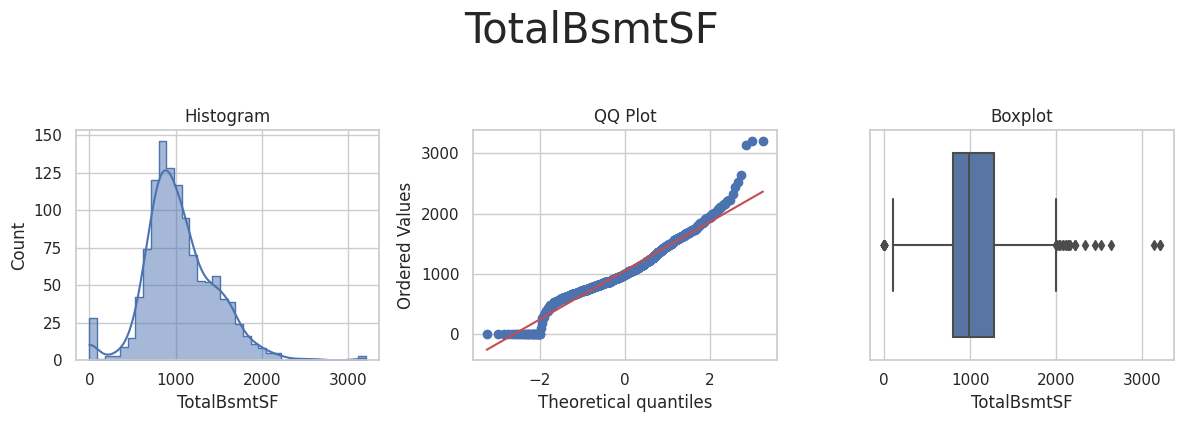

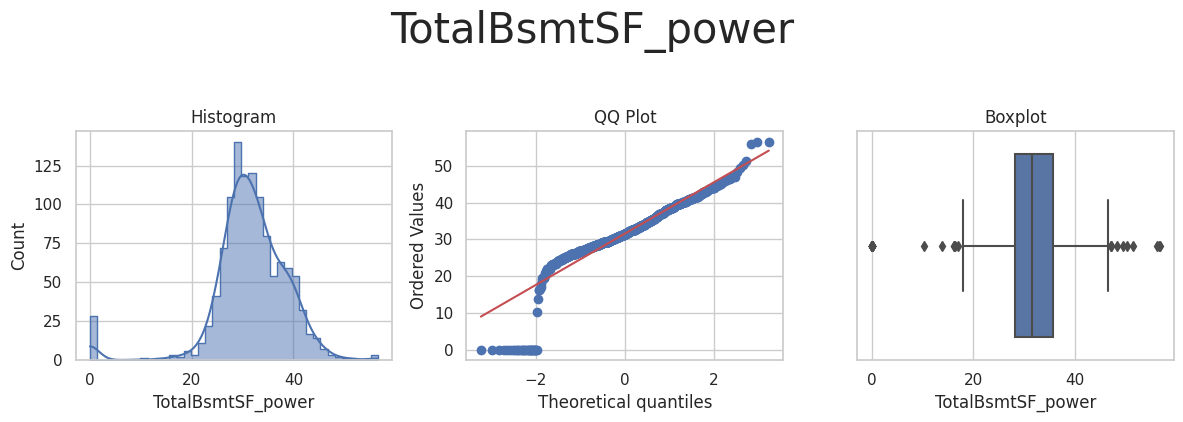

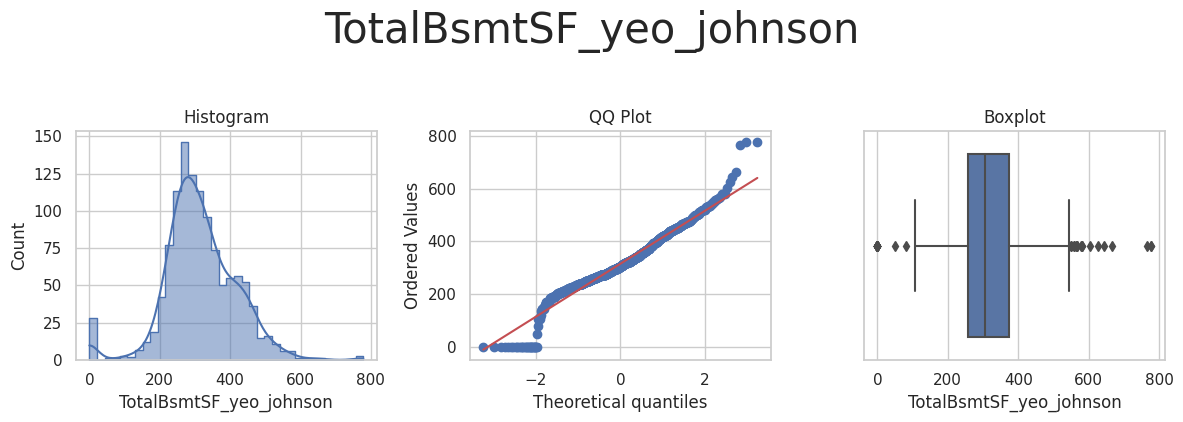



* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



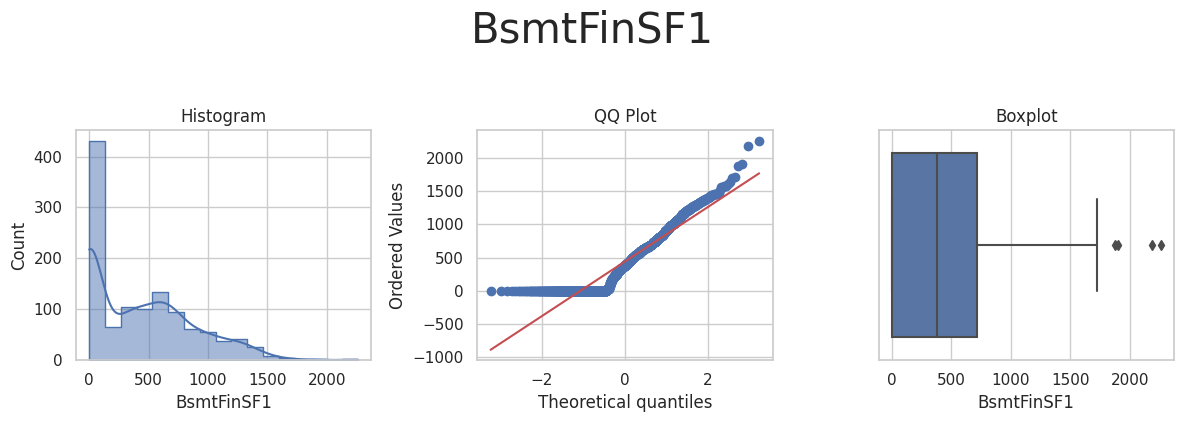

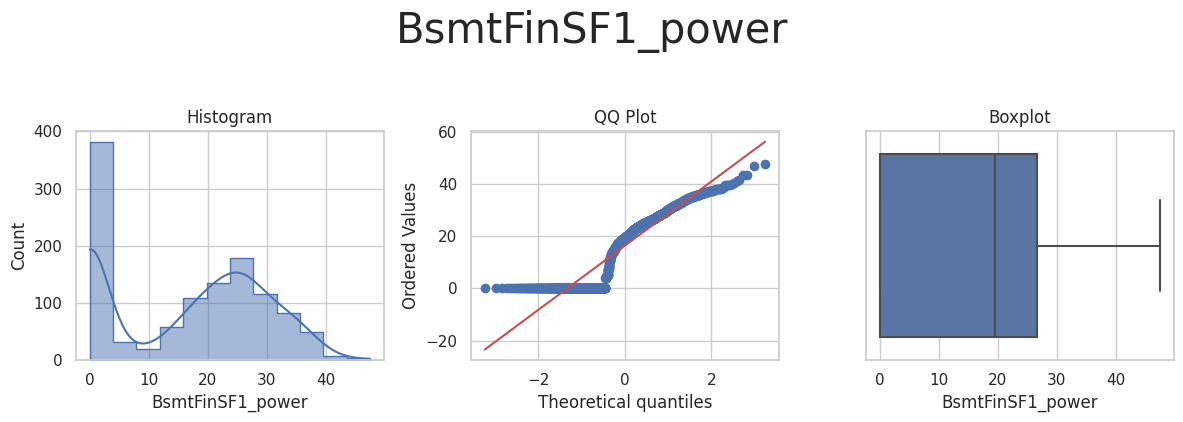

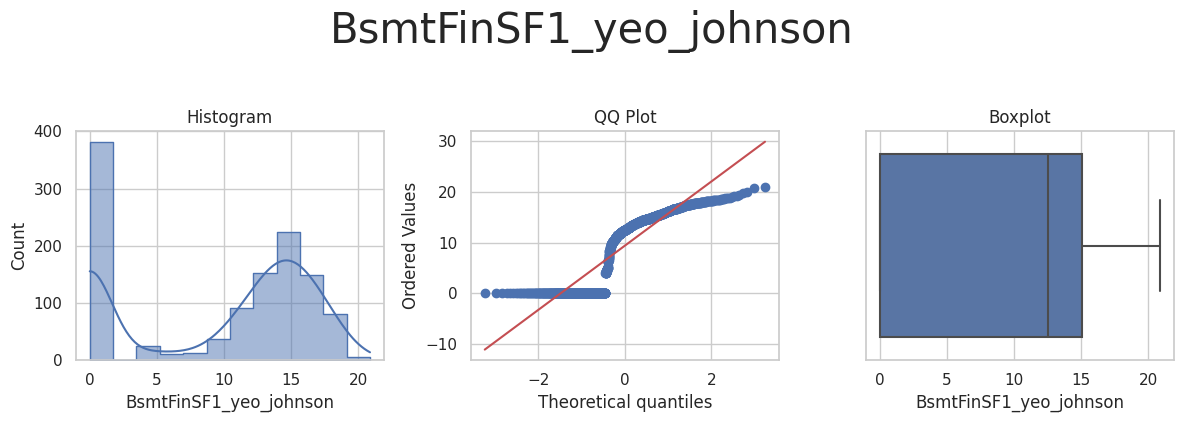



* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



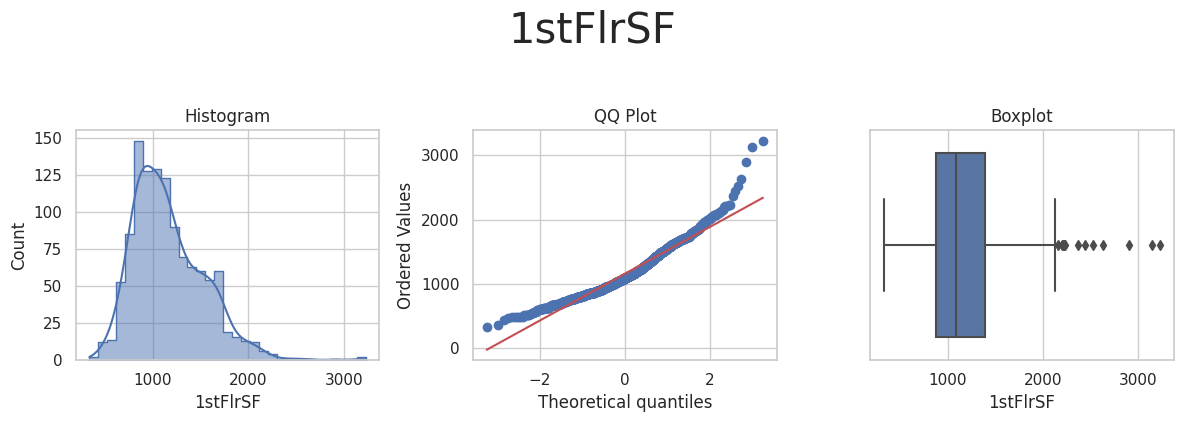

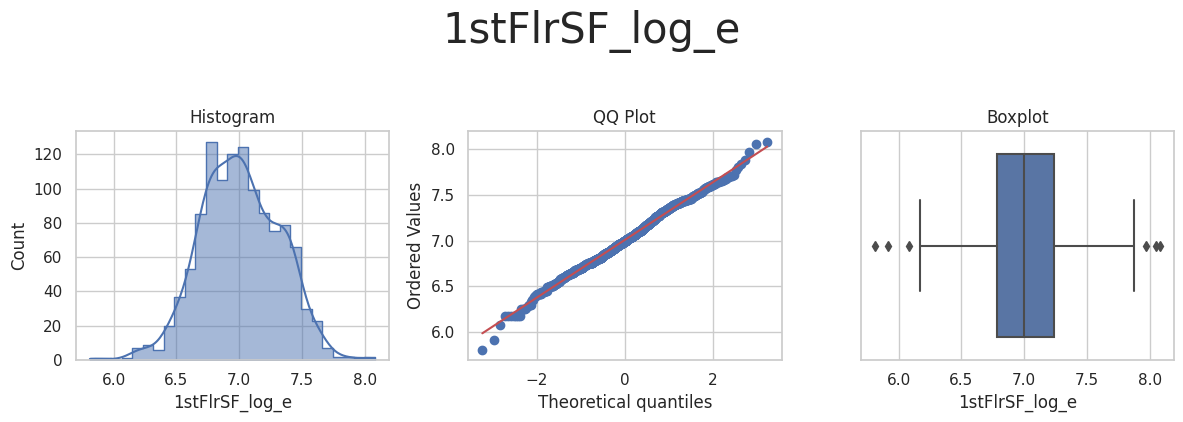

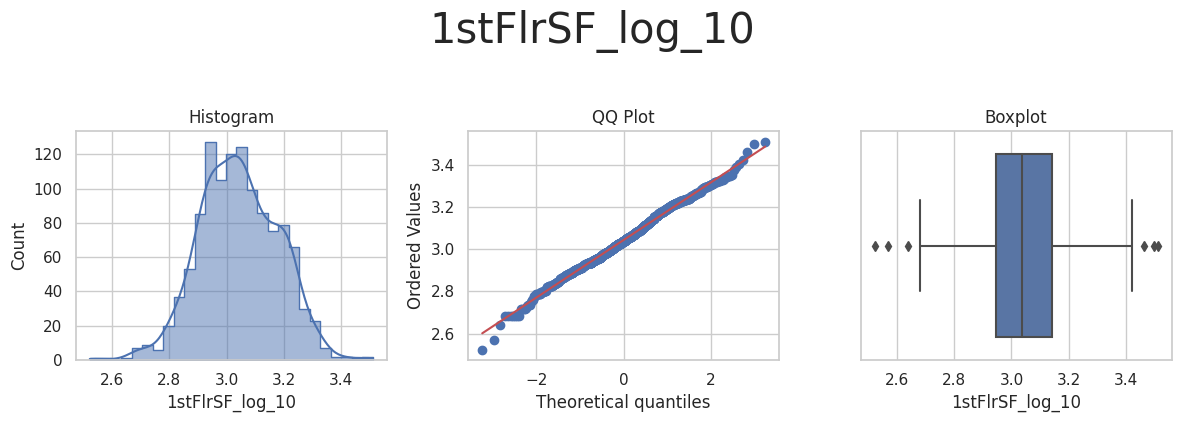

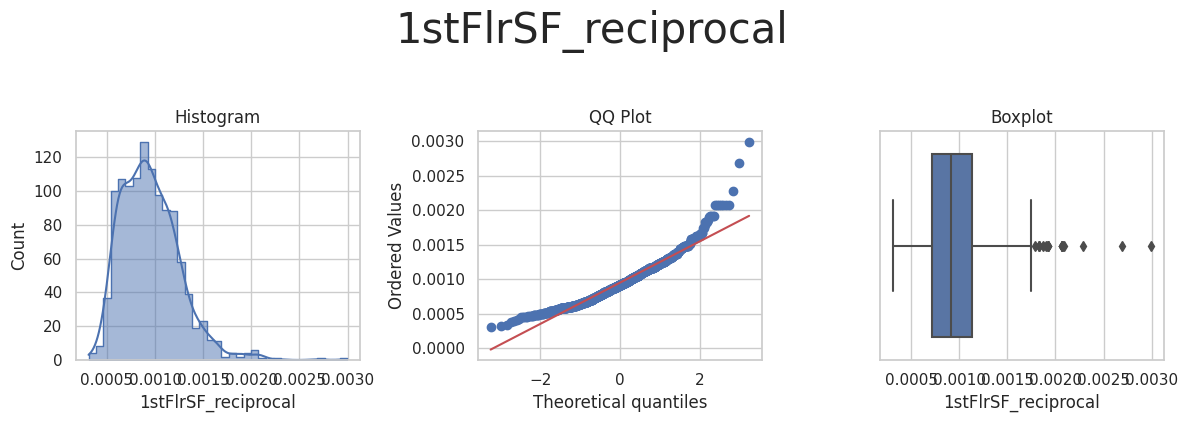

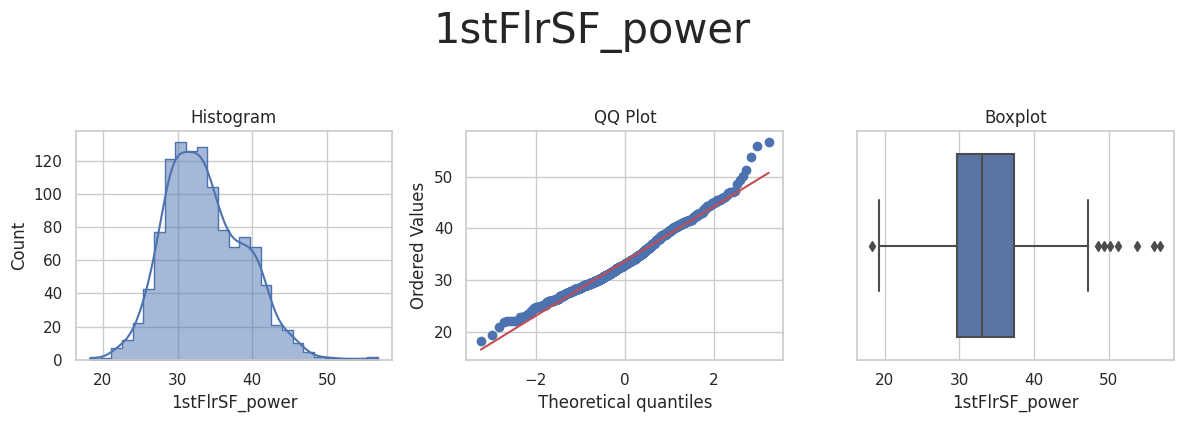

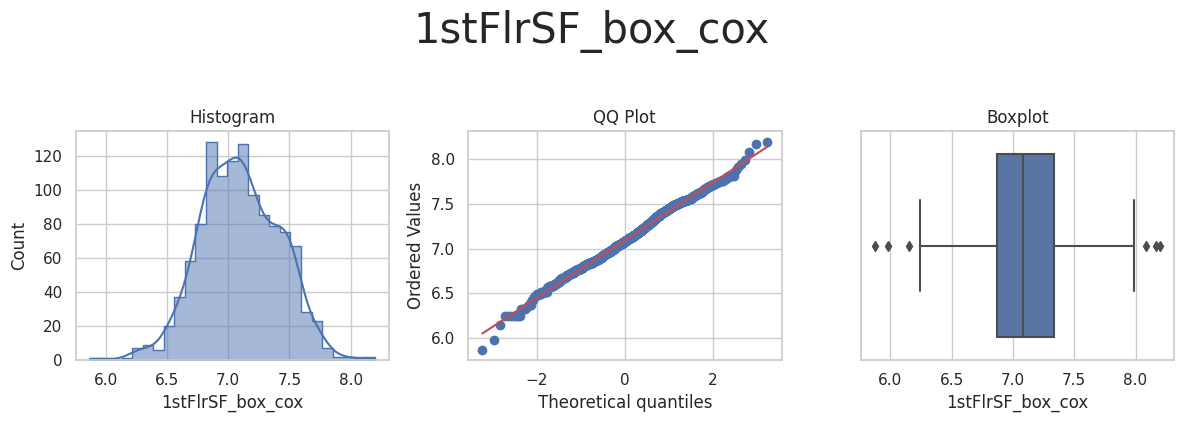

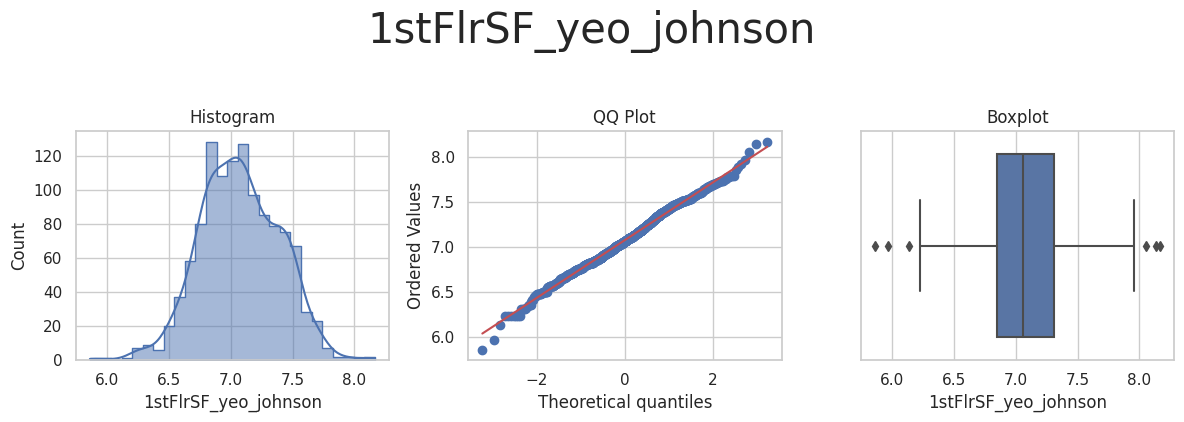



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



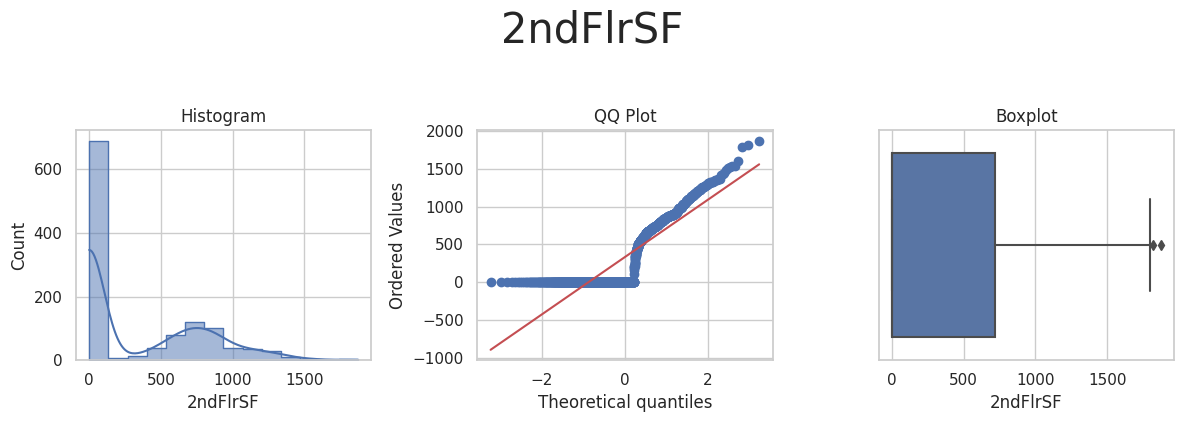

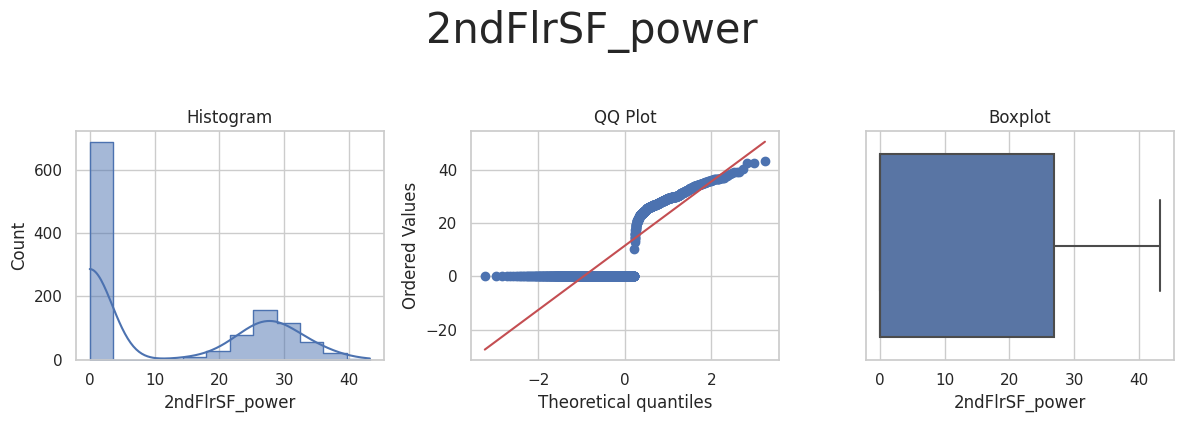

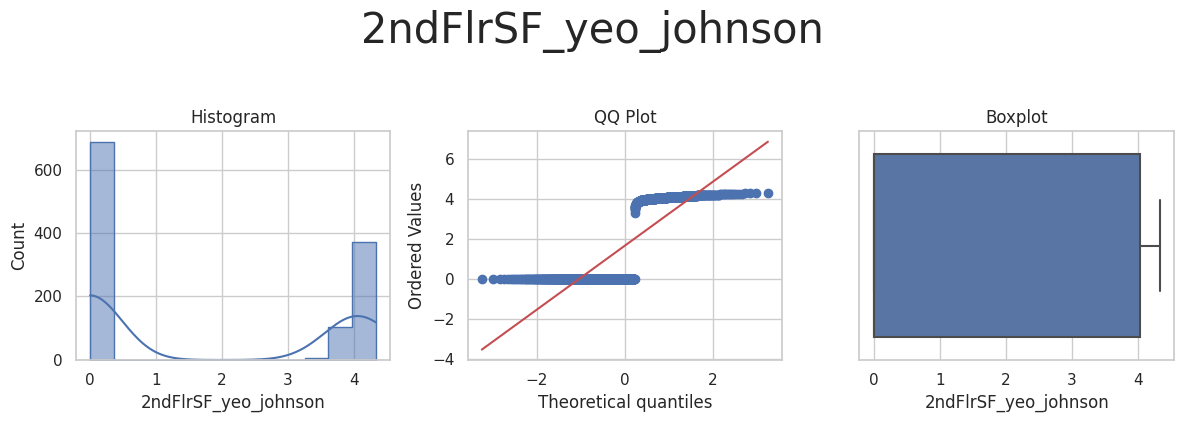

In [16]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

# Conclusions and Next Steps

The correlations and the interpretation of the graphs tell us that:

* 1stFlrSF, GarageArea, GarageYrBlt, TotalBsmtSF are showing a moderate correlation with the sale price.
* OverallQual, GrLivArea are showing a high correlation with the sale price.
* KitchenQual is showing consiredable higher sale price for properties with kitchens in excellent condition.
* MasVnrArea is showing a low-moderate correlation with the sale price.
* From 1980 onwards, an acceleration in price increases can be observed in YearBuilt and YearRemodAdd.

*Looking at the correlation analysis, we could suggest that quality, time and size are the variables that have the greatest influence on the selling price.*

#### Correlation-Interpretation:

* from 0,1 to 0,25 low correlation
* from 0,26 to 4,9 low-moderate correlation
* from 0,5 to 0,6 moderate correlation
* from 0,7 to 0,9 high correlation